In [59]:
import warnings
warnings.filterwarnings("ignore")
import joblib

import numpy as np
from datetime import datetime

from matplotlib import pyplot as plt
import json
import copy
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier, plot_importance, plot_tree
import pandas as pd
from sklearn import metrics
from sklearn2pmml import PMMLPipeline
from sklearn2pmml.decoration import CategoricalDomain, ContinuousDomain
from sklearn2pmml import sklearn2pmml
from sklearn.model_selection import train_test_split
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import OneHotEncoder, Imputer, LabelEncoder, StandardScaler
from sklearn.preprocessing import LabelBinarizer, FunctionTransformer, MaxAbsScaler
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn import model_selection
from sklearn2pmml.preprocessing import FeatureBinarizer
from sklearn2pmml import sklearn2pmml
from work.marvin.binary_classification_evaluation import binaryClassEvaluationPlots as evl
from work.marvin.binary_classifier_models import modelfit, modelDiagnose
from work.marvin.binary_classifier_models import bestLightgbmModelProducer

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import json
from tqdm import tqdm
import pickle 

# read data

In [60]:
# read file
with open('train.pkl', 'rb') as f:
    train = pickle.load(f)
with open('test.pkl', 'rb') as f:
    test = pickle.load(f)

In [61]:
# deal with time error
train['order_time'] = train['order_time'] + 1000*60*60*8
train.head(1)

,label,new_client,order_time,overdue,petime,pid,pname,pstime,sid,user_id
0,0.0,0.0,1.509352e+12,0.0,1.508170e+12,1508169825083X3005,loan_index,1.508170e+12,1508169825895,56f889ee11df4a72955147cb2f29a638


In [62]:
# get duration
# duration time(second) for each action
train['duration'] = (train['petime'] - train['pstime'])/1000

# get order_time-pstime
train['order_action_gap'] = (train['order_time'] - train['pstime'])/1000

In [63]:
# prepare data format

from datetime import datetime
def convert_to_date(train):
    # convert time to timestamp
    train['pstime'] = (train['pstime']//1000).apply(lambda x: datetime.fromtimestamp(x))
    train['petime'] = (train['petime']//1000).apply(lambda x: datetime.fromtimestamp(x))
    train['order_time'] = (train['order_time']/1000).apply(lambda x: datetime.fromtimestamp(x))
    return train

train = convert_to_date(train)

In [64]:
# data check
np.sum(~(train['pstime'] <= train['petime']))

3581

In [65]:
# kick out error: pstime > petime
train = train[train['pstime'] <= train['petime']]

# kick out pstime > order_time
# kick out petime > order_time
print(train.shape)
idx = (train['pstime'] <= train['order_time']) & (train['petime'] <= train['order_time'])
train = train[idx]
train.shape

(8530978, 12)


(7914754, 12)

In [66]:
# train = train.loc[:30]
# train

In [67]:
# get small sample for debug

gb = train.groupby(['user_id', 'order_time'])
data = []

cnt = 0
for name, group in gb:
#     print(cnt)
    group = group.sort_values(['pstime'])
    group.index = range(len(group))
    data.append((name, group))
    cnt = cnt + 1
    if cnt > 20:
        break
        

# feature engeering

In [68]:
# # agenda
# for each group:
#     # get windowed(15days, 1 month) data
    
#     # do statistical features
#     1.get statistics features for duration,
#     2.get statistics features for duration of different pages,
#     # statistic features include:
#         1.count, sum, mean,  
#         2.trends: std, absolute change, absoluate energy, fit coefs
#         3.rate:占比(还没做)

### get windowed data

In [69]:
def window_data(group, ts, size=30):   
    # get windowed ts
    idx = ((group['order_time']-group['pstime']).apply(lambda x: x.days<size)) & \
    ((group['order_time']-group['petime']).apply(lambda x: x.days<size))
    ts_wind = ts[idx]
    return ts_wind

# [window_data(data[i][1], data[i][1].duration) for i in range(len(data))]
# window_data(data[1][1], data[1][1].duration)

In [70]:
# page names
page_types = np.unique(train['pname'])
page_types

array(['bind_debit_card', 'biometric_auth', 'biometric_auto',
       'contacts_info', 'id_verify', 'loan_index', 'loan_submission',
       'login', 'operator', 'personal_info', 'register'], dtype=object)

In [71]:
def get_page_data(group, ts, page_name):
    idx = group['pname']==page_name
    ans = ts[idx]
    return ans
# for p in page_types:
#     print([get_page_data(data[i][1], data[i][1].duration, p) for i in range(len(data))])
#     print('\n')
get_page_data(data[1][1], data[1][1].duration,  'login')

0     12.451
17    12.272
Name: duration, dtype: float64

### get features

In [72]:
ts = data[1][1].duration
# ts

In [73]:
def basic_feats(ts):
    # special case
    if len(ts)==0:
        return [np.nan for i in range(7)]
    # normal case
    count_ = len(ts)
    sum_ = np.sum(ts)
    mean_ = np.mean(ts)
    min_ = np.min(ts)
    max_ = np.max(ts)
    q25 = np.quantile(ts, 0.25)
    q75 = np.quantile(ts, 0.75)
    return [count_, sum_, mean_, min_, max_, q25, q75]

# ts = [1,2,3,4,5]
basic_feats(ts)

[24, 525.965, 21.915208333333336, 0.392, 369.141, 3.2485, 9.469999999999999]

In [74]:
def trends_feature(ts):
    # special case
    if len(ts) == 0:
        return [np.nan,np.nan,np.nan]
    # normal case
    std_ = np.std(ts)
    abs_change = np.sum(np.diff(ts))
    abs_energy = np.sum([i*i for i in ts])
    return [std_, abs_change, abs_energy]

trends_feature(ts)

[72.59390040204204, -10.251999999999999, 138003.61756500002]

In [75]:
# trend advance eatures
def trends_adv_feats(x, chunk_size=2):
    # too short for agg
    if len(x) < chunk_size:
        return [np.nan,np.nan]
    
    # do aggregation
    aggs = []
    for i in range(len(x)-chunk_size):
        dat = x[i*chunk_size:(i+1)*chunk_size]
        if len(dat) != 0:
            aggs.append(np.mean(dat))

    n = len(aggs)
    # special case, singular matrix
    if  n==0:
        return [np.nan,np.nan]
    if n==1:
        return [np.nan,np.nan]
    
    # nonsepcial case
    aggs = np.array(aggs).reshape(-1,1)
    A = np.linspace(1, n, n).reshape(-1,1)
    A = np.hstack([np.ones(n).reshape(-1,1),A])

    # solve equations
    solu = (np.linalg.inv(A.T@A))@ (A.T@aggs)
    intercept = solu[0,0]
    slope = solu[1,0]
    return [intercept, slope]


# x = [1,2,3,4,5]
trends_adv_feats(ts)

[13.894424242424208, 1.233966783216788]

In [76]:
def _get_feats(ts):
    # basic features
    bas_feats = basic_feats(ts)
    
    # trend features
    tre_feats = trends_feature(ts)
    treadv_feats_2 = trends_adv_feats(ts,2)
    treadv_feats_5 = trends_adv_feats(ts,5)
    
    features = bas_feats + tre_feats + treadv_feats_2 + treadv_feats_5
    return features


In [77]:
def get_feature(group, col, size=15):
    # get features for each group
    feature = []
    
    ts = group[col]
    # get windowed ts
    ts = window_data(group, ts, size)
    feature.extend(_get_feats(ts))
    
    # split ts by page_name and extract features in the same way
    for page_name in page_types:
        sub_ts = get_page_data(group, ts, page_name)
        
        add_feats = _get_feats(sub_ts)
#         print(page_name, sub_ts, add_feats)
        feature.extend(add_feats)
    return feature    

# feats = get_feature(data[1][1], 'duration')
# feats

In [78]:
# construct names
def combine_names(ts_name):
    # get colnames for each stat_item
    def get_feature_names(window_size):
        names = []
        basic_names = ['count', 'sum', 'mean', 'min', 'max','q25', 'q75',
                       'std','abs_change', 'abs_energy', 'intercept_2', 'slope_2', 'intercept_5', 'slope_5']
        names.extend(basic_names)

        # names for each page
        for p in page_types:
            nam_ = [p+'.'+i for i in basic_names]
            names.extend(nam_)
        names = [window_size+'.'+i for i in names]
        return names
    
    col_names = get_feature_names('fifteen_days') + get_feature_names('thirty_days')
    return [ts_name+'.'+i for i in col_names]

col_names = combine_names('duration') #+ combine_names('order_action_gap')
col_names

['duration.fifteen_days.count',
 'duration.fifteen_days.sum',
 'duration.fifteen_days.mean',
 'duration.fifteen_days.min',
 'duration.fifteen_days.max',
 'duration.fifteen_days.q25',
 'duration.fifteen_days.q75',
 'duration.fifteen_days.std',
 'duration.fifteen_days.abs_change',
 'duration.fifteen_days.abs_energy',
 'duration.fifteen_days.intercept_2',
 'duration.fifteen_days.slope_2',
 'duration.fifteen_days.intercept_5',
 'duration.fifteen_days.slope_5',
 'duration.fifteen_days.bind_debit_card.count',
 'duration.fifteen_days.bind_debit_card.sum',
 'duration.fifteen_days.bind_debit_card.mean',
 'duration.fifteen_days.bind_debit_card.min',
 'duration.fifteen_days.bind_debit_card.max',
 'duration.fifteen_days.bind_debit_card.q25',
 'duration.fifteen_days.bind_debit_card.q75',
 'duration.fifteen_days.bind_debit_card.std',
 'duration.fifteen_days.bind_debit_card.abs_change',
 'duration.fifteen_days.bind_debit_card.abs_energy',
 'duration.fifteen_days.bind_debit_card.intercept_2',
 'durati

In [79]:
import pickle
with open('data/col_names_f.pickle', 'wb') as f:
    pickle.dump(col_names, f)

In [80]:
# save data
def save_data(fname1, fname2,all_feature, key):
    with open(fname1, 'wb') as f:
        pickle.dump(all_feature, f)
    with open(fname2, 'wb') as f:
        pickle.dump(key, f)
    return

In [1]:
from tqdm import tqdm
def get_all_features(gb, num_obs=10000):
    all_feature = []
    key = []
    cnt = 0
    for name, group in gb:
        print(cnt)
        # group dataframe
        group = group.sort_values(['pstime'])
        group.index = range(len(group))
        
        # feature extraction based on duration
        feat_duration_15day = get_feature(group, 'duration',size=15) 
        feat_duration_30day = get_feature(group, 'duration',size=30) 
#         # feature extraction based on order_time-pstime
#         feat_gap_15day = get_feature(group, 'order_action_gap',size=15) 
#         feat_gap_30day = get_feature(group, 'order_action_gap',size=30) 
        
        # combine all features
        all_feature.append(feat_duration_15day+feat_duration_30day)
#                           +feat_gap_15day+feat_gap_30day)
        key.append(list(name))
        cnt += 1
#         if cnt > num_obs:
#             break
#         if cnt == 10000:
#             # save data
#             save_data('data/all_feature_1.pickle', 'data/key_1.pickle', all_feature, key)
        if cnt == 30000:
            # save data
            save_data('data/all_feature_3.pickle', 'data/key_3.pickle', all_feature, key)
        if cnt == 70000:
            # save data
            save_data('data/all_feature_7.pickle', 'data/key_7.pickle', all_feature, key)
        if cnt == 100000:
            # save data
            save_data('data/all_feature_10.pickle', 'data/key_10.pickle', all_feature, key)
        
    return all_feature, key


gb = train.groupby(['user_id', 'order_time']) # make group object
all_feature, key = get_all_features(gb)


In [ ]:
# save data
import pickle
with open('data/all_feature_f.pickle', 'wb') as f:
    pickle.dump(all_feature, f)

with open('data/key_f.pickle', 'wb') as f:
    pickle.dump(key, f)

In [35]:
# import pickle
# with open('data/all_feature.pickle', 'wb') as f:
#     pickle.dump(all_feature, f)

# with open('data/key.pickle', 'wb') as f:
#     pickle.dump(key, f)

In [34]:
import pickle
with open('data/all_feature.pickle', 'rb') as f:
    all_feature = pickle.load(f)

with open('data/key.pickle', 'rb') as f:
    key = pickle.load(f)

In [36]:
len(col_names)

240

In [37]:
df = pd.DataFrame(all_feature, columns=col_names)
print(df.shape)
df.head()

(20001, 240)


,fifteen_days.count,fifteen_days.sum,fifteen_days.mean,fifteen_days.std,fifteen_days.abs_change,fifteen_days.abs_energy,fifteen_days.intercept_2,fifteen_days.slope_2,fifteen_days.intercept_5,fifteen_days.slope_5,...,thirty_days.register.count,thirty_days.register.sum,thirty_days.register.mean,thirty_days.register.std,thirty_days.register.abs_change,thirty_days.register.abs_energy,thirty_days.register.intercept_2,thirty_days.register.slope_2,thirty_days.register.intercept_5,thirty_days.register.slope_5
0,13.0,246.287,18.945154,17.060375,-7.651,8449.678349,18.832000,-0.217179,25.881378,-4.237233,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,24.0,525.965,21.915208,72.593900,-10.252,138003.617565,13.894424,1.233967,25.862340,-1.576980,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,16.0,177.417,11.088562,16.481292,-8.024,6313.427515,-1.270125,2.746375,6.891100,1.131740,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,27.0,239.599,8.874037,16.433417,-11.429,9417.754563,13.279868,-0.627597,10.812153,-0.386563,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,49.0,435.897,8.895857,6.221126,-14.188,5774.095345,7.979400,0.066908,8.224390,0.103577,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
keys = pd.DataFrame(key, columns=['user_id', 'order_time'])
print(keys.shape)
keys.head()

(20001, 2)


,user_id,order_time
0,00003b4ceb224e1b977c242bbf767ea0,2017-10-25 15:59:00
1,00008a736dcc4d099436cda07d41bdc4,2017-10-08 20:18:00
2,00008a736dcc4d099436cda07d41bdc4,2017-10-22 02:03:00
3,0000c645196245c489a9bd3a0cf4a92a,2017-10-15 21:15:00
4,0000fa4f719e4f5f940823c12978116c,2017-10-19 23:44:00


In [39]:

for c in df.columns:
    zero_ratio = np.sum(df[[c]]==0)/len(df)
    print(zero_ratio)

fifteen_days.count    0.0
dtype: float64
fifteen_days.sum    0.0
dtype: float64
fifteen_days.mean    0.0
dtype: float64
fifteen_days.std    0.0059
dtype: float64
fifteen_days.abs_change    0.0059
dtype: float64
fifteen_days.abs_energy    0.0
dtype: float64
fifteen_days.intercept_2    0.0
dtype: float64
fifteen_days.slope_2    0.0
dtype: float64
fifteen_days.intercept_5    0.0
dtype: float64
fifteen_days.slope_5    0.0
dtype: float64
fifteen_days.bind_debit_card.count    0.0
dtype: float64
fifteen_days.bind_debit_card.sum    0.0
dtype: float64
fifteen_days.bind_debit_card.mean    0.0
dtype: float64
fifteen_days.bind_debit_card.std    0.032798
dtype: float64
fifteen_days.bind_debit_card.abs_change    0.032798
dtype: float64
fifteen_days.bind_debit_card.abs_energy    0.0
dtype: float64
fifteen_days.bind_debit_card.intercept_2    0.0
dtype: float64
fifteen_days.bind_debit_card.slope_2    0.0
dtype: float64
fifteen_days.bind_debit_card.intercept_5    0.0
dtype: float64
fifteen_days.bind_deb

thirty_days.personal_info.abs_change    0.00545
dtype: float64
thirty_days.personal_info.abs_energy    0.0
dtype: float64
thirty_days.personal_info.intercept_2    0.0
dtype: float64
thirty_days.personal_info.slope_2    0.0001
dtype: float64
thirty_days.personal_info.intercept_5    0.0
dtype: float64
thirty_days.personal_info.slope_5    0.0
dtype: float64
thirty_days.register.count    0.0
dtype: float64
thirty_days.register.sum    0.0
dtype: float64
thirty_days.register.mean    0.0
dtype: float64
thirty_days.register.std    0.170741
dtype: float64
thirty_days.register.abs_change    0.170791
dtype: float64
thirty_days.register.abs_energy    0.0
dtype: float64
thirty_days.register.intercept_2    0.0
dtype: float64
thirty_days.register.slope_2    0.0
dtype: float64
thirty_days.register.intercept_5    0.0
dtype: float64
thirty_days.register.slope_5    0.0
dtype: float64


(array([36.,  2.,  4.,  0.,  0., 14., 32.,  8.,  6.,  6.,  2., 32.,  0.,
         0.,  2.,  2.,  0.,  0.,  4.,  0., 12., 10.,  6., 12., 50.]),
 array([4.99975001e-05, 4.00479976e-02, 8.00459977e-02, 1.20043998e-01,
        1.60041998e-01, 2.00039998e-01, 2.40037998e-01, 2.80035998e-01,
        3.20033998e-01, 3.60031998e-01, 4.00029999e-01, 4.40027999e-01,
        4.80025999e-01, 5.20023999e-01, 5.60021999e-01, 6.00019999e-01,
        6.40017999e-01, 6.80015999e-01, 7.20013999e-01, 7.60011999e-01,
        8.00010000e-01, 8.40008000e-01, 8.80006000e-01, 9.20004000e-01,
        9.60002000e-01, 1.00000000e+00]),
 <a list of 25 Patch objects>)

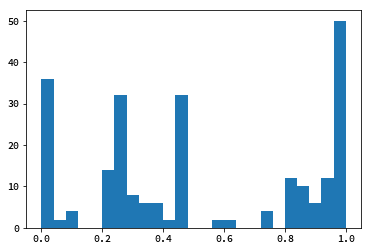

In [40]:
cov = df.isnull().sum(axis=0)/len(df)
plt.hist(cov, bins=25)

In [41]:
label = gb['label'].head(1)
label.index = range(len(label))
label

0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
199732    0.0
199733    0.0
199734    1.0
199735    0.0
199736    0.0
Name: label, Length: 199737, dtype: float64

# model


In [42]:
import warnings
warnings.filterwarnings("ignore")
import joblib

import numpy as np
from datetime import datetime

from matplotlib import pyplot as plt
import json
import copy
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier, plot_importance, plot_tree
import pandas as pd
from sklearn import metrics
from sklearn2pmml import PMMLPipeline
from sklearn2pmml.decoration import CategoricalDomain, ContinuousDomain
from sklearn2pmml import sklearn2pmml
from sklearn.model_selection import train_test_split
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import OneHotEncoder, Imputer, LabelEncoder, StandardScaler
from sklearn.preprocessing import LabelBinarizer, FunctionTransformer, MaxAbsScaler
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn import model_selection
from sklearn2pmml.preprocessing import FeatureBinarizer
from sklearn2pmml import sklearn2pmml
from work.marvin.binary_classification_evaluation import binaryClassEvaluationPlots as evl
from work.marvin.binary_classifier_models import modelfit, modelDiagnose
from work.marvin.binary_classifier_models import bestLightgbmModelProducer

In [56]:
with open('data/label.pickle', 'wb') as f:
    pickle.dump(y, f)

In [43]:
X = df
y = label.loc[:len(X)-1]
train = pd.concat([X,y], axis=1)
train.head(2)

,fifteen_days.count,fifteen_days.sum,fifteen_days.mean,fifteen_days.std,fifteen_days.abs_change,fifteen_days.abs_energy,fifteen_days.intercept_2,fifteen_days.slope_2,fifteen_days.intercept_5,fifteen_days.slope_5,...,thirty_days.register.sum,thirty_days.register.mean,thirty_days.register.std,thirty_days.register.abs_change,thirty_days.register.abs_energy,thirty_days.register.intercept_2,thirty_days.register.slope_2,thirty_days.register.intercept_5,thirty_days.register.slope_5,label
0,13.0,246.287,18.945154,17.060375,-7.651,8449.678349,18.832000,-0.217179,25.881378,-4.237233,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,24.0,525.965,21.915208,72.593900,-10.252,138003.617565,13.894424,1.233967,25.862340,-1.576980,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [44]:
train.shape

(20001, 241)

In [44]:
train, test = train_test_split(train, test_size=0.25, random_state=0)
train.shape, test.shape

((15000, 241), (5001, 241))

In [66]:
# train = train.fillna(0)

In [67]:
continuousDomain = []
categoricalDomain = []
target = 'label'

for columns in train.columns:
    if columns != 'label':
        if train[columns].dtypes != object:
            continuousDomain.append(columns)
        else:
            categoricalDomain.append(columns)
            

dfm_LabelEncoder = DataFrameMapper([(continuousDomain, [ContinuousDomain(invalid_value_treatment='as_missing',
                                                                             missing_value_treatment='as_is'),Imputer()],
                                         {'union_cols': False})]
                                       +[(c,[CategoricalDomain(invalid_value_treatment='as_missing',
                                                               missing_value_treatment='as_mean',
                                                               missing_value_replacement = 'CreditX-NA'),
                                             LabelEncoder()])
                                         for c in categoricalDomain],
                                       df_out=True)

ans_LB = dfm_LabelEncoder.fit_transform(train.drop(columns=[target]), np.array(train[target]))



In [68]:
categoricalDomain

[]

In [69]:
lgbm_best_skopt = LGBMClassifier(boosting_type='gbdt', 
                                 class_weight=None,
                                 colsample_bytree=0.6, 
                                 importance_type='split',
                                 is_unbalance=True, 
                                 learning_rate=0.1, 
                                 max_bin=15,
                                 max_depth=3, 
                                 min_child_samples=500, 
                                 min_child_weight=0.001,
                                 min_split_gain=0.03, 
                                 n_estimators=600, 
                                 n_jobs=12,
                                 num_leaves=42, 
                                 objective='binary', 
                                 random_state=27, 
                                 reg_alpha=0,
                                 reg_lambda=0, 
                                 scale_pos_weight=1, 
                                 silent=False, 
                                 subsample=0.7,
                                 subsample_for_bin=200000, 
                                 subsample_freq=2)

In [70]:
lgb_pipeline = PMMLPipeline([('dfm', dfm_LabelEncoder),('lightGBM', lgbm_best_skopt)])
lgb_pipeline.fit(train[train.columns.difference([target])], train[target])

PMMLPipeline(steps=[('dfm', DataFrameMapper(default=False, df_out=True,
        features=[(['fifteen_days.count', 'fifteen_days.sum', 'fifteen_days.mean', 'fifteen_days.std', 'fifteen_days.abs_change', 'fifteen_days.abs_energy', 'fifteen_days.intercept_2', 'fifteen_days.slope_2', 'fifteen_days.intercept_5', 'fifteen_days.slope_5', 'fifteen_days.bind_debit_card.count', 'fifteen_...puter(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)], {'union_cols': False})],
        input_df=False, sparse=False)),
       ('lightGBM', LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.6,
        importance_type='split', is_unbalance=True, learning_rate=0.1,
        max_bin=15, max_depth=3, min_child_samples=500,
        min_child_weight=0.001, min_split_gain=0.03, n_estimators=600,
        n_jobs=12, num_leaves=42, objective='binary', random_state=27,
        reg_alpha=0, reg_lambda=0, scale_pos_weight=1, silent=False,
        subsample=0.7, subsample_for_bi


Model Report
AUC Score (Train): 0.910142
CV Score : Mean - 0.5351683 | Std - 0.0117474 | Min - 0.5233 | Max - 0.5511702


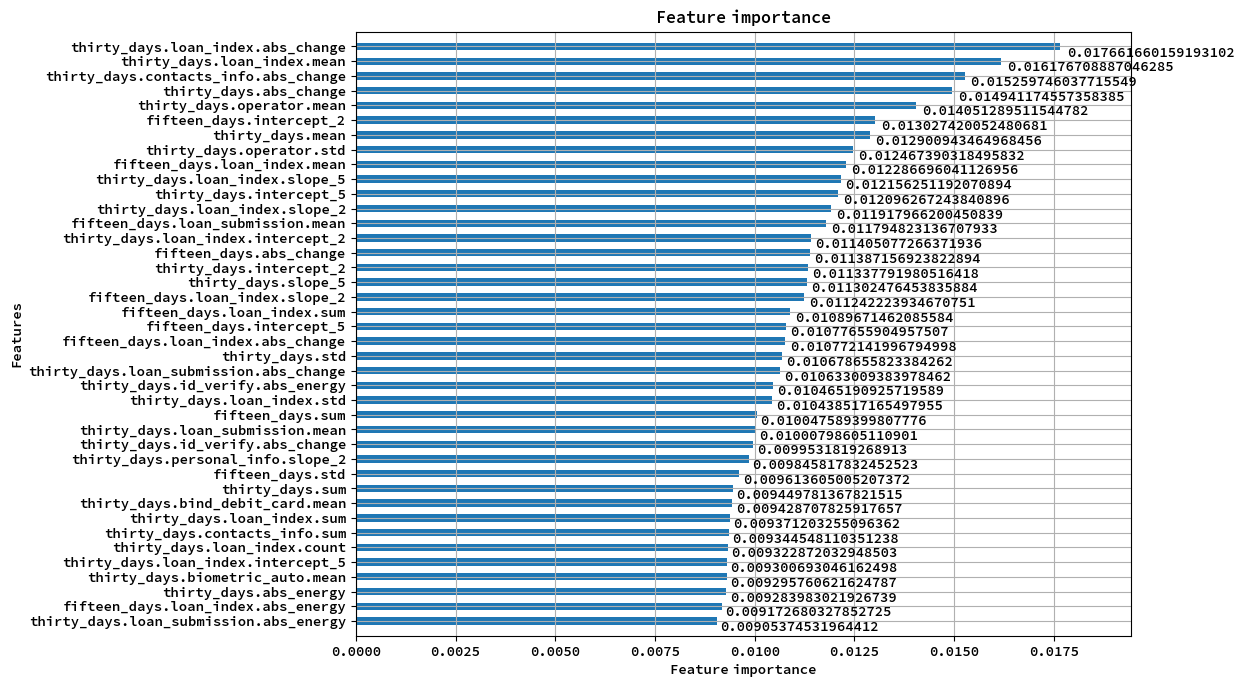

In [71]:
pipeline ,train_, predprob, auc, cv_score = modelfit.pipeline_fit(lgb_pipeline,train,target,cv=3)

In [72]:
pipeline.feature_importances_.T.head(10)

,ftr_importance
thirty_days.loan_index.abs_change,0.017662
thirty_days.loan_index.mean,0.016177
thirty_days.contacts_info.abs_change,0.015260
thirty_days.abs_change,0.014941
thirty_days.operator.mean,0.014051
fifteen_days.intercept_2,0.013027
thirty_days.mean,0.012901
thirty_days.operator.std,0.012467
fifteen_days.loan_index.mean,0.012287
thirty_days.loan_index.slope_5,0.012156


0.4974840462729049


(0.035112392168803686, 0.33, 0.06, 0.24)

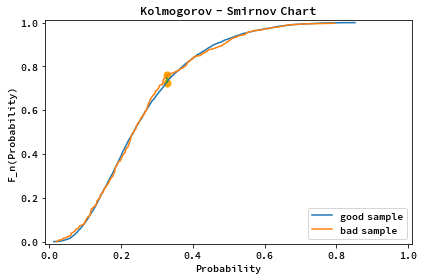

In [73]:
pipeline, test_, predprob = modelfit.pipelinePredict(lgb_pipeline, test, target)
auc = metrics.roc_auc_score(y_score=predprob['predprob'], y_true = predprob['ytrue'])
print(auc)
evl.ks_curve(Y_true = predprob['ytrue'], Y_predprob = predprob['predprob'],fig_path=None)

0.9101415023437429


(0.6726717988510442, 0.51, 0.25, 0.86)

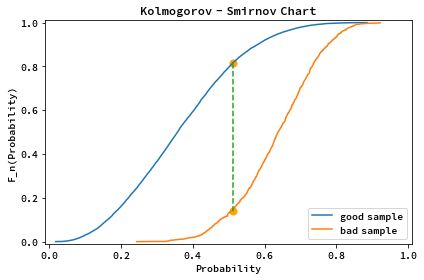

In [74]:
pipeline, train_, predprob = modelfit.pipelinePredict(lgb_pipeline, train, target)
auc = metrics.roc_auc_score(y_score=predprob['predprob'], y_true = predprob['ytrue'])
print(auc)
evl.ks_curve(Y_true = predprob['ytrue'], Y_predprob = predprob['predprob'],fig_path=None)

# LR baseline

In [45]:
X = df
y = label.loc[:len(X)-1]

# Nans
print(X.isnull().sum(axis=0))
X = X.fillna(0)

# scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

my_features = X
for c in my_features.columns:
    my_features[[c]] = scaler.fit_transform(my_features[[c]])
    

fifteen_days.count                    112
fifteen_days.sum                      112
fifteen_days.mean                     112
fifteen_days.std                      112
fifteen_days.abs_change               112
                                    ...  
thirty_days.register.abs_energy     16584
thirty_days.register.intercept_2    20001
thirty_days.register.slope_2        20001
thirty_days.register.intercept_5    20001
thirty_days.register.slope_5        20001
Length: 240, dtype: int64


In [46]:
# split
import sklearn
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=29)
X_train.shape, X_test.shape

((15000, 240), (5001, 240))

In [47]:
len(keys)

20001

In [48]:
from sklearn.linear_model import LogisticRegression
mod = LogisticRegression()
mod.fit(X_train, y_train)
tr_sc = mod.score(X_train, y_train)
te_sc = mod.score(X_test, y_test)
print('train score: %f | test score: %f' %(tr_sc,te_sc))

y_pred = mod.predict_proba(X_test)[:,1]


train score: 0.922467 | test score: 0.914817


(0.04257659205718256, 0.07, 0.09, 0.7)

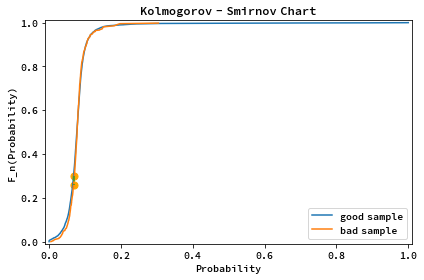

In [49]:
evl.ks_curve(y_test, y_pred, fig_path=None)